# <center>Explanatory Data Analysis (EDA) and Model Selection for Property Price Prediction on a Dataset "House Sales in King County, USA"</center>

## Introduction

In today's circumstances, considering the dynamics of the property market, it is essential to estimate the property price. Whether one wants to make an investment decision, get a loan, or sell their property, it is important to make sure the price is fair according to the market condition. Property price predictions are vital for informed decision-making, risk management, and strategic planning in real estate and related sectors. Having statistics on the prices of properties in the vicinity, we can estimate with good enough precision the price of the given house.

The goal of this project is to create and compare models to predict house prices in King County.
This is a **_supervised learning regression problem_**, as the price is a continuous value. We will create a Multiple Linear Regression Model (**MLRM**) without interaction terms as a baseline. We will compare then the two different models, GAM and LightGBM, with the baseline. We will select the best at the end.

**GAMs** states for Generalized Additive Models. GAM is a type of regression model that allows for flexible relationships between the independent and dependent variables. In opposition to the MLRM, GAMs use smooth functions to model complex relationships.

**LightGBM** (Light Gradient Boosting Machine) is a powerful and efficient decision tree gradient-boosting framework developed by Microsoft. It is designed for speed and efficiency in training large datasets.


In [40]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from pygam import LinearGAM, s, f, l, te
import lightgbm as lgb
from lightgbm import LGBMRegressor

## Dataset
The dataset for this project is publicly available on Kaggle: [House Sales in King County, USA](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction?resource=download). It includes homes sold between May 2014 and May 2015.

It is tabulated data and contains the next features:

**id** - unique ID<br>
**date** - date at which the home was sold<br>
**price** - the price of the deal<br>
**bedrooms** - number of bedrooms<br>
**bathrooms** - number of bathrooms. 0.5 accounts for a room with a toilet but no shower<br>
**sqft_living** - the area of the living space (in square feet)<br>
**sqft_lot** - the area of the land space (in square feet)<br>
**floors** - number of floors<br>
**waterfront** - weather property overlooks the waterfront<br>
**view** - an index from 0 to 4 of how good the view of the property was<br>
**condition** - an index on the condition of the apartment (1 - Poore, 2 - Fair, 3 - Average, 4 - Good, 5 - Very Good)<br>
**grade** - an index from 1 to 13. It reflects the structure, furnishings, and construction of the house. (1 - Cabin, 2 - Substandard, 3 - Poore, 4 - Low, 5 - Fair, 6 - Low Average, 7 - Average, 8 - Good, 9 - Better, 10 - Very Good, 11 -Excellent, 12 - Luxury, 13 - Mansion)<br>
**sqft_above** - area of the interior housing space that is above ground level (in square feet)<br>
**sqft_basement** - area of the interior housing space that is below ground level (in square feet)<br>
**yr_built** - the year the house was built<br>
**yr_renovated** - the year of the property's last renovation<br>
**zipcode** - zip code area of the property<br>
**lat** - latitude <br>
**long** - longitude<br>
**sqft_living15** - average area of living space for the nearest 15 neighbors (in square feet)<br>
**sqft_lot15** - average area of the land lots of the nearest 15 neighbors (in square feet)<br>

Let's load the dataset and figure out it size:

In [41]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('data/kc_house_data.csv')
df.shape

(21613, 21)

So, the dataset has 21 features and 21613 rows.

Let's figure out the data types:

In [42]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

It seems like the pandas didn't properly parse the categorical features. Like waterfront is either has a waterfront view (1) or doesn't (0). But it is parsed as an integer.

We will deal with this kind of issue in the data cleaning section.

## Data Cleaning and Feature Selection

During the cleaning, we are going to find if there are missing data and outliers. 

Let's check if we have any missing data:

In [43]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

The dataset has no null/na value. So, we don't need to deal with it. Just leave it as is.

The issue we have is that waterfront, view, condition, grade, and zipcode are categorical. But pandas parsed them as integers. Let's fix it.
Another issue is that for pyGAM, all categorical features should start from 0. In this dataset grade and condition star from 1. So, let's fix this either.

In [44]:
df['condition'] = df['condition']-1
df['grade'] = df['grade']-1

df['zipcode'] = df['zipcode'].astype('category')
df['condition'] = df['condition'].astype('category')
df['grade'] = df['grade'].astype('category')
df['waterfront'] = df['waterfront'].astype('category')
df['view'] = df['view'].astype('category')
df.describe(include='all')

id             date         price      bedrooms  \
count   2.161300e+04            21613  2.161300e+04  21613.000000   
unique           NaN              372           NaN           NaN   
top              NaN  20140623T000000           NaN           NaN   
freq             NaN              142           NaN           NaN   
mean    4.580302e+09              NaN  5.400881e+05      3.370842   
std     2.876566e+09              NaN  3.671272e+05      0.930062   
min     1.000102e+06              NaN  7.500000e+04      0.000000   
25%     2.123049e+09              NaN  3.219500e+05      3.000000   
50%     3.904930e+09              NaN  4.500000e+05      3.000000   
75%     7.308900e+09              NaN  6.450000e+05      4.000000   
max     9.900000e+09              NaN  7.700000e+06     33.000000   

           bathrooms   sqft_living      sqft_lot        floors  waterfront  \
count   21613.000000  21613.000000  2.161300e+04  21613.000000     21613.0   
unique           NaN           NaN           NaN           NaN         2.0   
top              NaN           NaN           NaN           NaN         0.0   
freq             NaN           NaN           NaN           NaN     21450.0   
mean        2.114757   2079.899736  1.510697e+04      1.494309         NaN   
std         0.770163    918.440897  4.142051e+04      0.539989         NaN   
min         0.000000    290.000000  5.200000e+02      1.000000         NaN   
25%         1.750000   1427.000000  5.040000e+03      1.000000         NaN   
50%         2.250000   1910.000000  7.618000e+03      1.500000         NaN   
75%         2.500000   2550.000000  1.068800e+04      2.000000         NaN   
max         8.000000  13540.000000  1.651359e+06      3.500000         NaN   

           view  condition    grade    sqft_above  sqft_basement  \
count   21613.0    21613.0  21613.0  21613.000000   21613.000000   
unique      5.0        5.0     12.0           NaN            NaN   
top         0.0        2.0      6.0           NaN            NaN   
freq    19489.0    14031.0   8981.0           NaN            NaN   
mean        NaN        NaN      NaN   1788.390691     291.509045   
std         NaN        NaN      NaN    828.090978     442.575043   
min         NaN        NaN      NaN    290.000000       0.000000   
25%         NaN        NaN      NaN   1190.000000       0.000000   
50%         NaN        NaN      NaN   1560.000000       0.000000   
75%         NaN        NaN      NaN   2210.000000     560.000000   
max         NaN        NaN      NaN   9410.000000    4820.000000   

            yr_built  yr_renovated  zipcode           lat          long  \
count   21613.000000  21613.000000  21613.0  21613.000000  21613.000000   
unique           NaN           NaN     70.0           NaN           NaN   
top              NaN           NaN  98103.0           NaN           NaN   
freq             NaN           NaN    602.0           NaN           NaN   
mean     1971.005136     84.402258      NaN     47.560053   -122.213896   
std        29.373411    401.679240      NaN      0.138564      0.140828   
min      1900.000000      0.000000      NaN     47.155900   -122.519000   
25%      1951.000000      0.000000      NaN     47.471000   -122.328000   
50%      1975.000000      0.000000      NaN     47.571800   -122.230000   
75%      1997.000000      0.000000      NaN     47.678000   -122.125000   
max      2015.000000   2015.000000      NaN     47.777600   -121.315000   

        sqft_living15     sqft_lot15  
count    21613.000000   21613.000000  
unique            NaN            NaN  
top               NaN            NaN  
freq              NaN            NaN  
mean      1986.552492   12768.455652  
std        685.391304   27304.179631  
min        399.000000     651.000000  
25%       1490.000000    5100.000000  
50%       1840.000000    7620.000000  
75%       2360.000000   10083.000000  
max       6210.000000  871200.000000

In [45]:
df.dtypes

id                  int64
date               object
price             float64
bedrooms            int64
bathrooms         float64
sqft_living         int64
sqft_lot            int64
floors            float64
waterfront       category
view             category
condition        category
grade            category
sqft_above          int64
sqft_basement       int64
yr_built            int64
yr_renovated        int64
zipcode          category
lat               float64
long              float64
sqft_living15       int64
sqft_lot15          int64
dtype: object

Another thing is that the date is an object, not a DateTime. Let's fix it:

In [47]:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront             category
view                   category
condition              category
grade                  category
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                category
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

<Axes: xlabel='yr_renovated', ylabel='Count'>

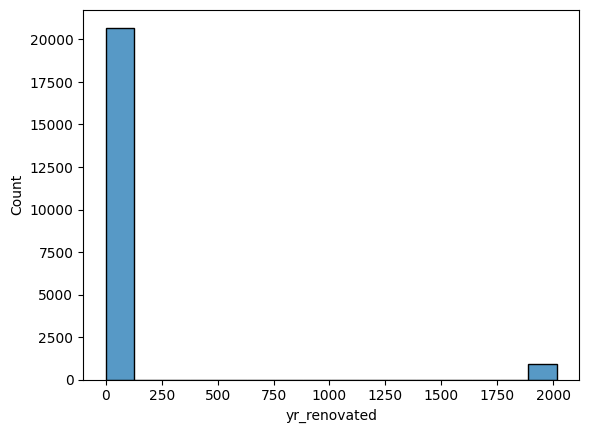

In [48]:
sns.histplot(data=df, x="yr_renovated")

Let's do some feature engineering. The yr_renovated has 0 if the property has not been renovated since it was built. 
The more important thing is how new the interior is. That's why we will create a feature called 'interior_age'.
The dataset is for 2014-2015 years. So, we will assume today is 2015.

<Axes: xlabel='interior_age', ylabel='Count'>

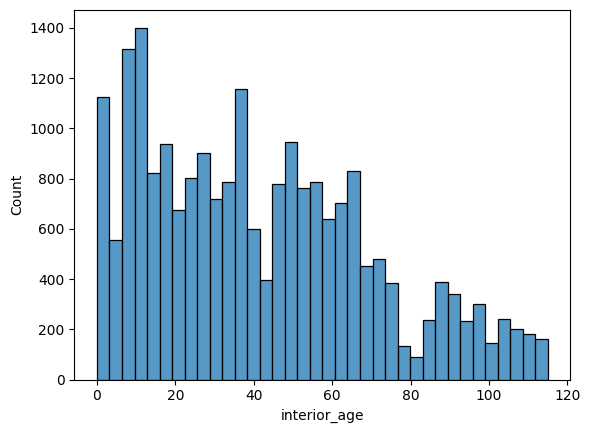

In [49]:
df['interior_age'] = 2015 - np.where(df['yr_renovated'] == 0, df['yr_built'], df['yr_renovated'])
sns.histplot(data=df, x="interior_age")

Let's take a look at the histogram for the price predictor:

<Axes: xlabel='price', ylabel='Count'>

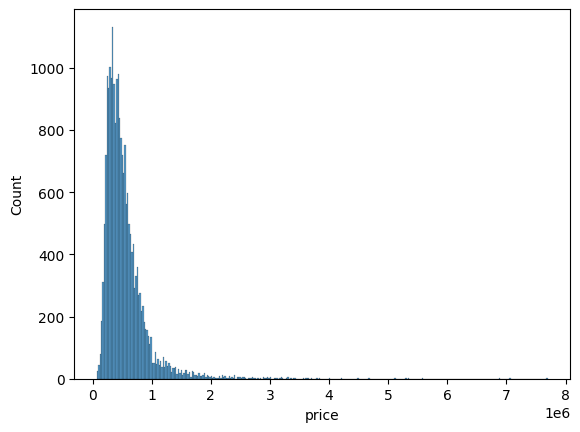

In [50]:
sns.histplot(data=df, x="price")

It looks like it has outliers. For this variable, I will consider 1.5 of IQR outside the IQR to be outliers. Let's remove them.

<Axes: xlabel='price', ylabel='Count'>

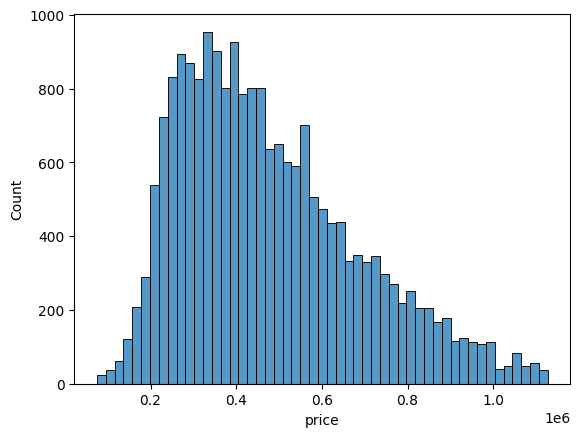

In [51]:
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
iqr = q3 - q1

lower_bound = max(q1-1.5*iqr, 0)
upper_bound = q3 + 1.5 * iqr
df_woo = df[(df['price']<upper_bound) & (df['price']>lower_bound)]
sns.histplot(data=df_woo, x="price")

The next histogram shows that likely bedrooms feature has also outliers:

<Axes: xlabel='bedrooms', ylabel='Count'>

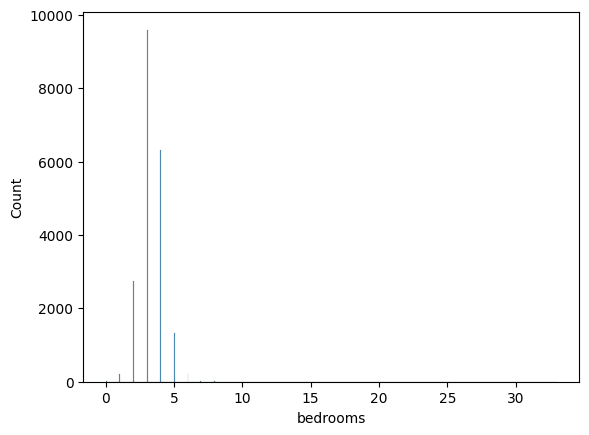

In [52]:
sns.histplot(data=df_woo, x="bedrooms")

This time, we will consider values outside $\mu \pm 3\sigma$ outliers and remove them

<Axes: xlabel='bedrooms', ylabel='Count'>

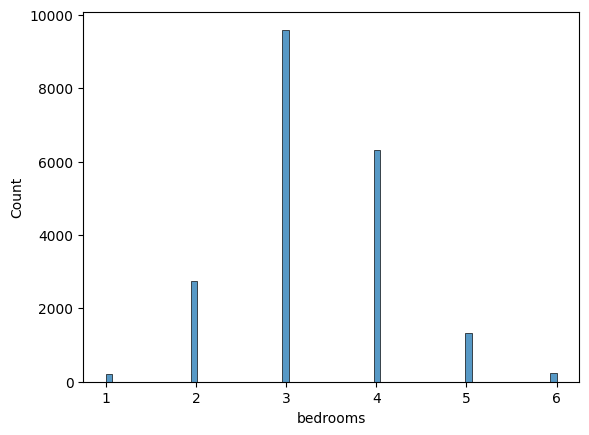

In [53]:
df_woo = df_woo[(np.abs(stats.zscore(df_woo['bedrooms'])) < 3)]
sns.histplot(data=df_woo, x="bedrooms")

Let's continue with feature selection. At first, let's drop those, which we obviously won't need. Like id (it has no meaning), yr_renovated (we will use the new feature 'interior_age'), date (we will not do temporal analysis), zipcode (assuming it duplicates coordinates)
sqft_living and sqft_above are essentially the same. So, we won't include sqft_living into predictors. 


In [54]:
df_final = df_woo[['price', 'bedrooms', 'bathrooms', 
                   'sqft_lot', 'floors', 
                   'waterfront', 'view', 'condition', 'grade',
                   'sqft_above', 'sqft_basement', 
                   'yr_built', 'interior_age', 'lat', 'long',
                   'sqft_living15', 'sqft_lot15']]

Let's see if there are outliers among the numeric columns:

In [55]:
# Choose only numeric columns
num_columns = df_final.select_dtypes(include=[np.number]).columns

df_final[num_columns][(stats.zscore(df_final[num_columns]) >= 3).all(axis=1)].sum()

price            0.0
bedrooms         0.0
bathrooms        0.0
sqft_lot         0.0
floors           0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
interior_age     0.0
lat              0.0
long             0.0
sqft_living15    0.0
sqft_lot15       0.0
dtype: float64

Great, there are no outliers.

## Exploratory Data Analysis

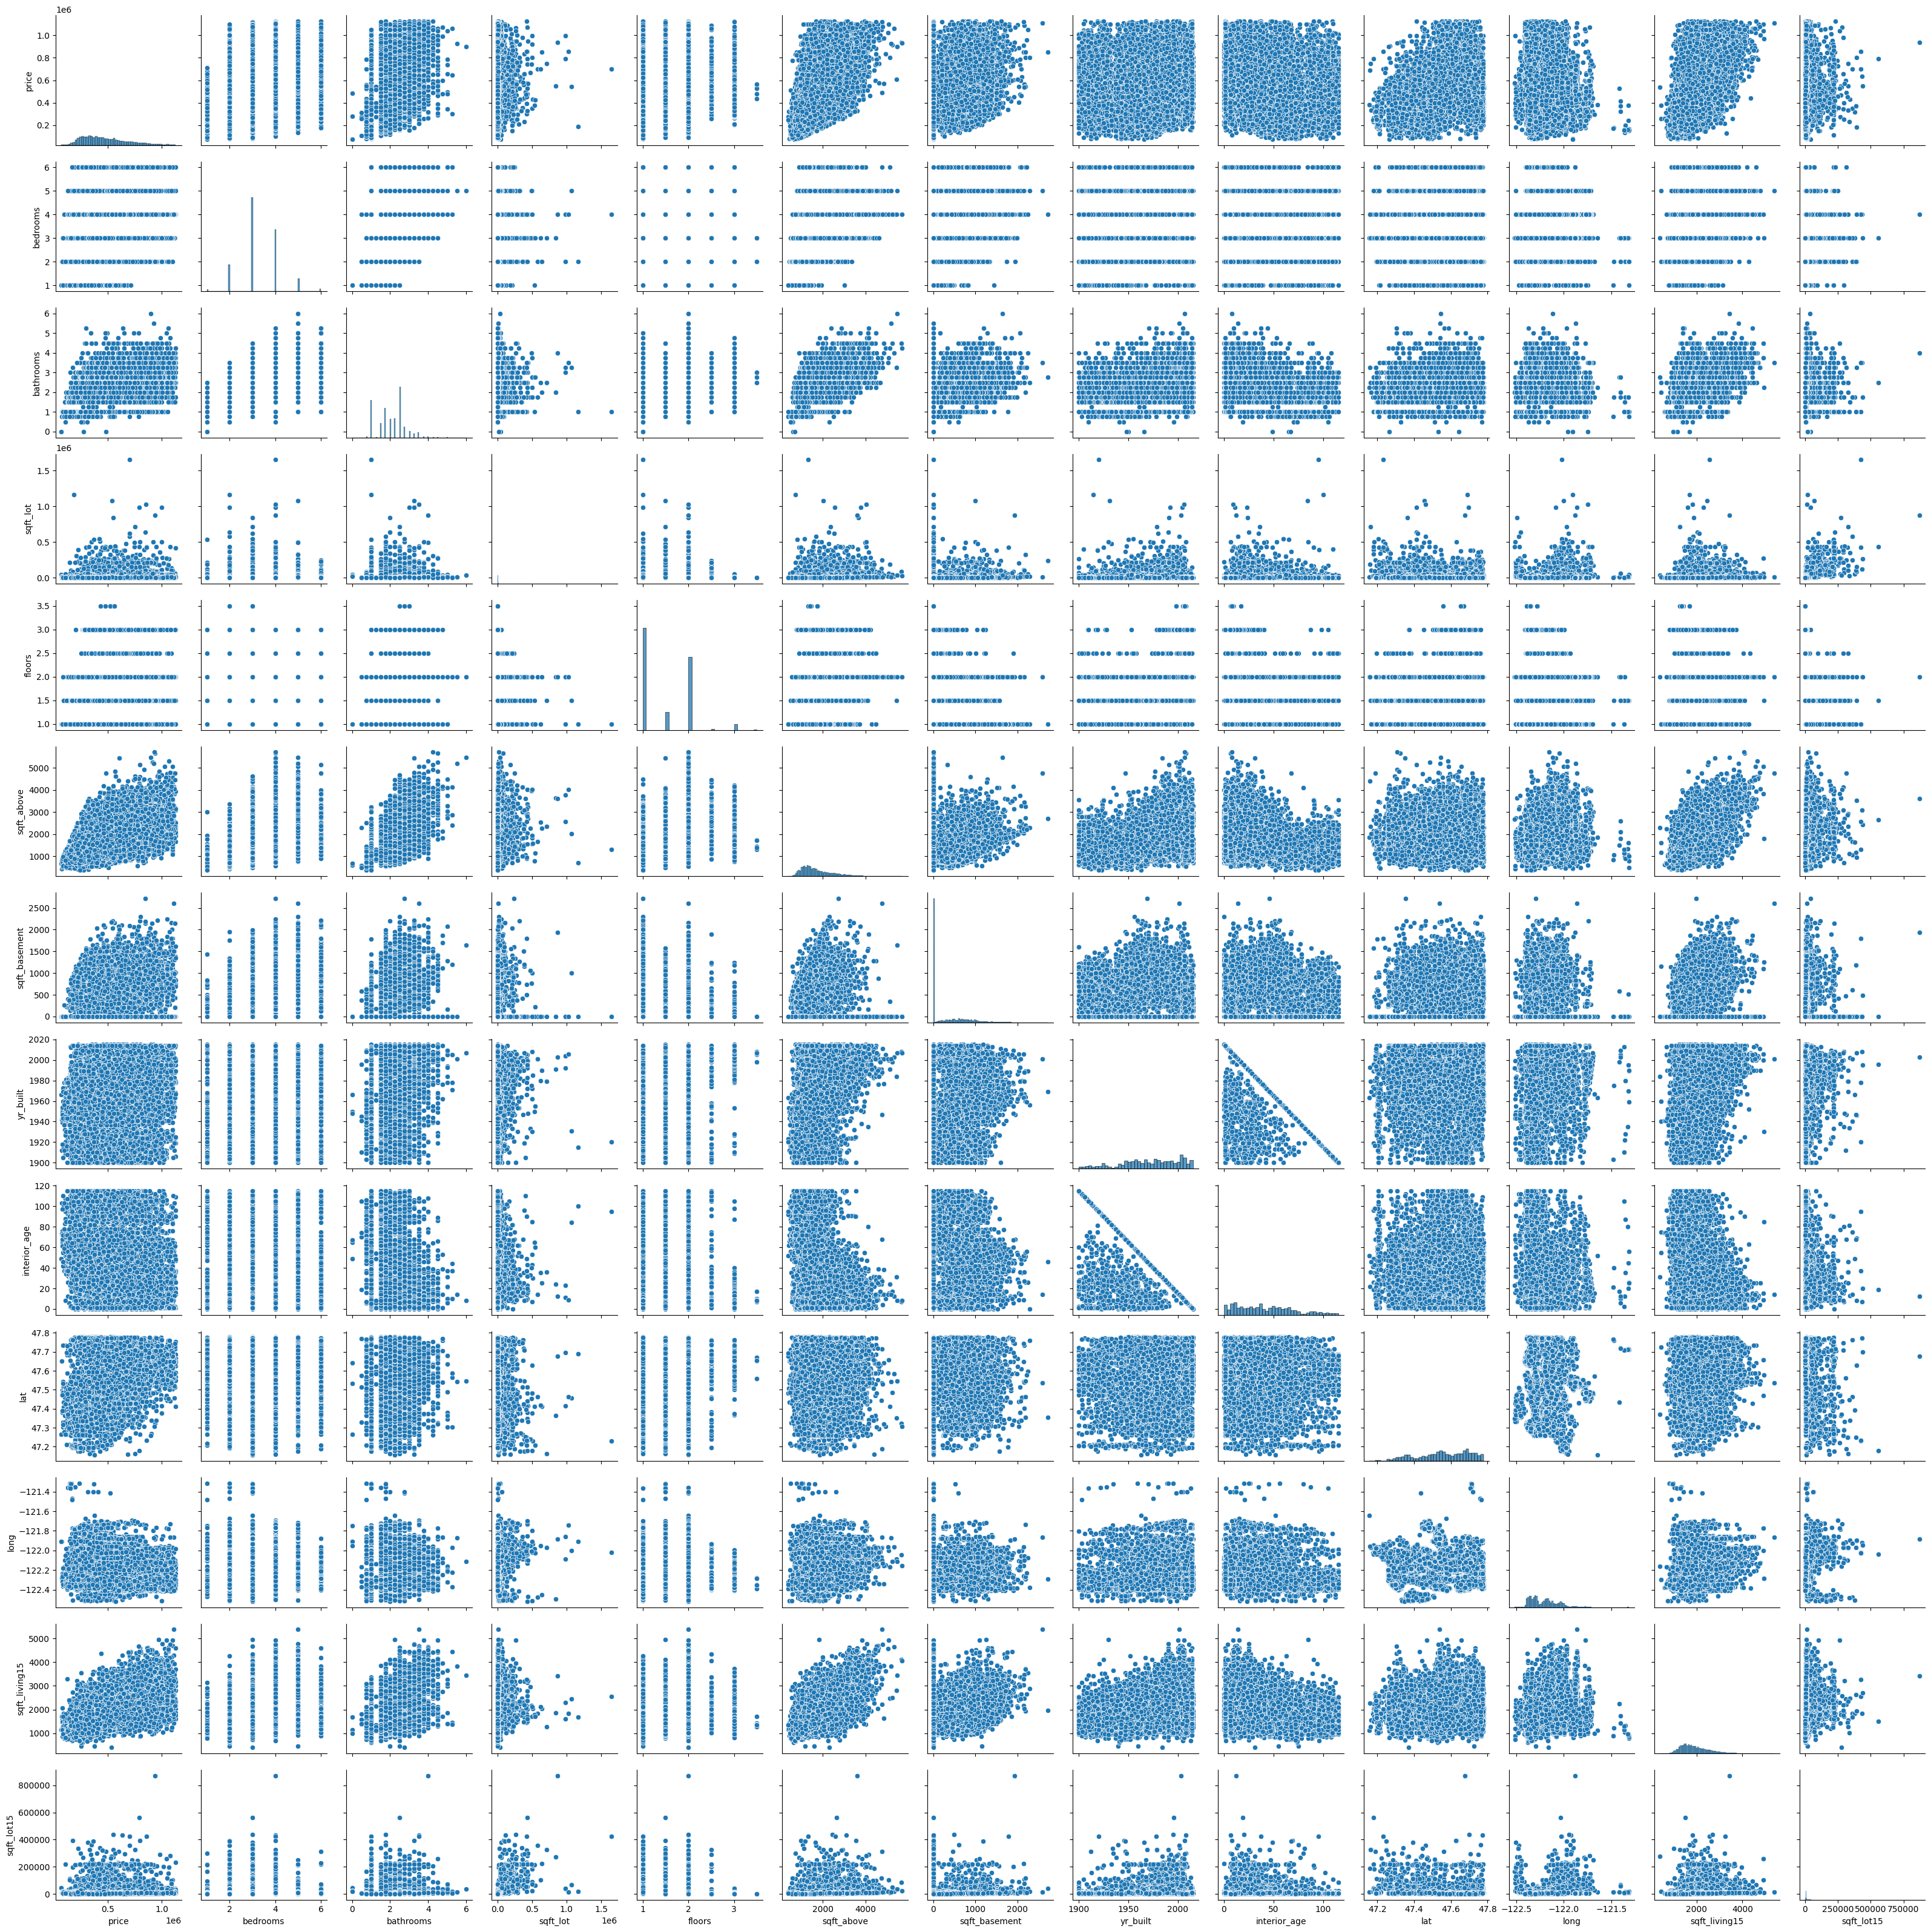

In [16]:
sns.pairplot(df_final)

Let's build a correlation matrix and check if we have highly correlated features.

<Axes: >

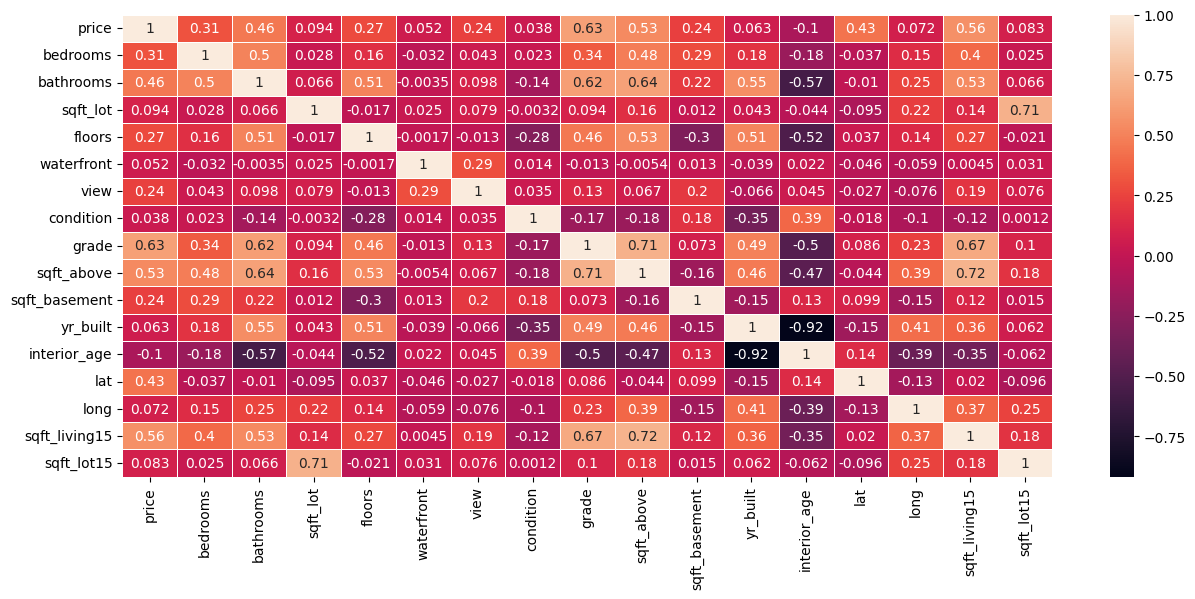

In [56]:
# Enlirege the heatmap a bit
plt.figure(figsize=(15,6))

sns.heatmap(df_final.corr(), annot=True, linewidths=.5)

There are some features correlated. Like:
sqft_lot is correlated with sqft_lot15. Which is expected. Usually, the bigger your lot, the bigger the lots of your neighbors.
grade is correlated with sqft_above, sqft_living15, bathrooms and price. Again, this is expected. Because grades, as well as the rest mentioned, represent a kind of level of the property.

Even though the variables are correlated, we will not remove them from the dataset. Because they give us additional data, we don't want to lose.

## Model Selection
Here, we will try different regression models to estimate the price of the property. The base will be a multiple linear regression model (MLRM), then we will fit a generalized additive model (GAM) and will conclude with decision tree ensemble-based LightGBM.

To measure performance, we will use mean absolute percentage error (MAPE). Even though the mean squared error (MSE) is better in terms of statistical modeling, MAPE is better for human understanding.

To be able to validate the performance of models, we will split our dataset to train and test in proportions of 80% for train and 20% for test.

In [57]:
X=df_final[['bedrooms', 'bathrooms', 
   'sqft_lot', 'floors', 
   'waterfront', 'view', 'condition', 'grade',
   'sqft_above', 'sqft_basement', 
   'yr_built', 'interior_age', 'lat', 'long',
   'sqft_living15', 'sqft_lot15']].to_numpy()

y=df_final['price'].to_numpy()

#Split data to train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1212)

#### Features regularization

In [58]:
# Fit standard scaler on train data. 
# We should not use the entire dataset in oreder not to include information about entire dataset into train set
scaler = StandardScaler().fit(X_train)

# Perform regularization
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

#### MLRM

In [59]:
mlr = sm.OLS(endog=y_train, exog=sm.add_constant(X_train_sc)).fit()
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     2316.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        17:37:07   Log-Likelihood:            -2.1339e+05
No. Observations:               16326   AIC:                         4.268e+05
Df Residuals:                   16309   BIC:                         4.269e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.761e+05    899.456    529.318      0.0

In [60]:
y_hat = mlr.predict(sm.add_constant(X_test_sc))
mean_absolute_percentage_error(y_pred=y_hat, y_true=y_test)

np.float64(0.19882282413152216)

#### Residuals vs Fitted

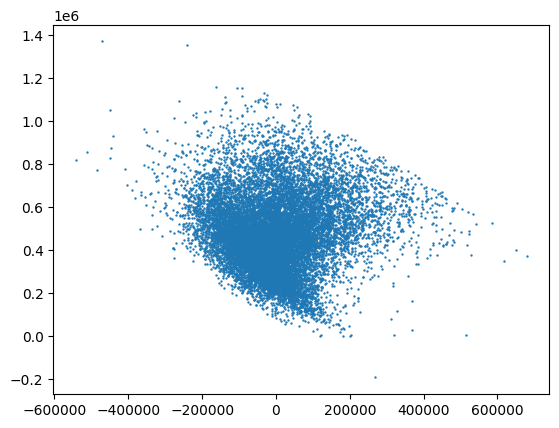

In [61]:
y_fitted = mlr.predict(sm.add_constant(X_train_sc))
y_resid = mlr.resid
plt.scatter(y_resid, y_fitted, s=0.5)
plt.show()

The residual vs fitted indicates a slight issue with linearity. However, it doesn't indicate any issue with homoscedasticity. 

#### Multicollinearity
1. The Durbin-Watson test for autocorrelation is near 2. It means no issue with multicollinearity.
2. Let's check variance inflation factor (VIF):

In [62]:
df_mc = df_final.drop(['price'], axis=1)

df_vif = pd.DataFrame()

df_vif['feature'] = df_mc.columns
df_vif['VIF'] = [variance_inflation_factor(df_mc.values, i) for i in range(df_mc.shape[1])]

df_vif

feature            VIF
0        bedrooms      27.086345
1       bathrooms      28.884546
2        sqft_lot       2.304461
3          floors      17.212390
4      waterfront       1.108968
5            view       1.311851
6       condition      18.196027
7           grade     111.521431
8      sqft_above      30.253525
9   sqft_basement       2.835400
10       yr_built   28156.964686
11   interior_age      21.964169
12            lat  116196.819395
13           long  143006.452206
14  sqft_living15      29.622201
15     sqft_lot15       2.522211

Here are three predictors with huge VIF: yr_built, lat, and long. Let's remove two of them with the biggest VIF: long and yr_built:

In [63]:
df_vif = pd.DataFrame()

df_no_mc = df_final.drop(['price','long', 'yr_built'], axis=1)

df_vif['feature'] = df_no_mc.columns
df_vif['VIF'] = [variance_inflation_factor(df_no_mc.values, i) for i in range(df_no_mc.shape[1])]
df_vif

feature         VIF
0        bedrooms   26.986272
1       bathrooms   28.788593
2        sqft_lot    2.303802
3          floors   17.150787
4      waterfront    1.105983
5            view    1.291563
6       condition   18.104866
7           grade  110.560586
8      sqft_above   30.187008
9   sqft_basement    2.791404
10   interior_age    6.411875
11            lat  111.610731
12  sqft_living15   28.891258
13     sqft_lot15    2.520758

Much better. Let's fit the MLRM and check the performance: 

In [64]:
X_mc=df_final[['bedrooms', 'bathrooms', 
   'sqft_lot', 'floors', 
   'waterfront', 'view', 'condition', 'grade',
   'sqft_above', 'sqft_basement', 
   'interior_age', 'lat', 
   'sqft_living15', 'sqft_lot15']].to_numpy()

y_mc=df_final['price'].to_numpy()

X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(X_mc, y_mc, test_size=0.20, random_state=1212)

scaler_mc = StandardScaler().fit(X_train_mc)
X_train_sc_mc = scaler_mc.transform(X_train_mc)
X_test_sc_mc = scaler_mc.transform(X_test_mc)

mlr_mc = sm.OLS(endog=y_train_mc, exog=sm.add_constant(X_train_sc_mc)).fit()
print(mlr_mc.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     2480.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        17:39:26   Log-Likelihood:            -2.1375e+05
No. Observations:               16326   AIC:                         4.275e+05
Df Residuals:                   16311   BIC:                         4.277e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.761e+05    919.817    517.601      0.0

In [65]:
y_hat = mlr_mc.predict(sm.add_constant(X_test_sc_mc))
mean_absolute_percentage_error(y_pred=y_hat, y_true=y_test_mc)

np.float64(0.20209341617468302)

We removed the collinear features. But the performance dropped a bit.
1. Adjusted $R^2$ dropped from 0.694 to 0.68
2. MAPE dropped from 19.9% to 20.2%
The drop is not significant. So we will choose the simpler model. 

#### GAM
On the fitted vs residual plot, we found that there is some non-linearity present in the data. 

GAM is a model which helps to overcome the issue with no linearity. Let's fit GAM to the data and see which terms should go as linear and which of them as splines. 

In [66]:
gam = LinearGAM(s(0)+s(1)+s(2)+s(3)+f(4)+f(5)+f(6)+f(7)+s(8)+s(9)+s(10)+s(11)+s(12)+s(13)+s(14)+s(15)).fit(X_train_sc, y_train)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    159.2293
Link Function:                     IdentityLink Log Likelihood:                               -387560.2133
Number of Samples:                        16326 AIC:                                           775440.8852
                                                AICc:                                          775444.0815
                                                GCV:                                       8284001196.4394
                                                Scale:                                     8138697929.9399
                                                Pseudo R-Squared:                                   0.8133
Feature Function                  Lam

/var/folders/w0/s_wz2zzx3ls7nn9kbl_5n25r0000gp/T/ipykernel_85055/518590733.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [67]:
y_hat = gam.predict(X_test_sc)
mean_absolute_percentage_error(y_pred=y_hat, y_true=y_test)

np.float64(0.15414487314691477)

The effective degrees of freedom (EDF) for some predictors are relatively low, less than 6. It indicates that the terms may be included as linear. Let's take a look at the partial feature dependency plots to decide which terms we will add to the model as linear. 

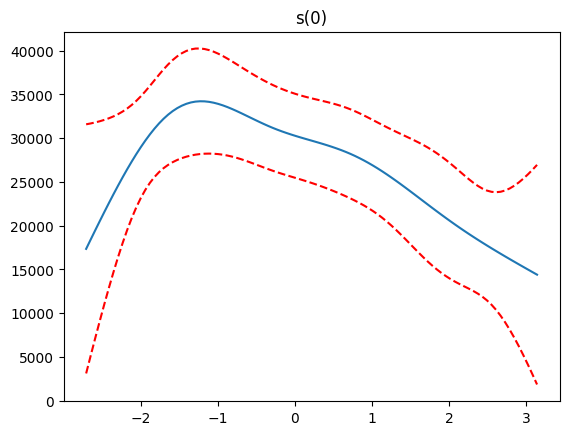

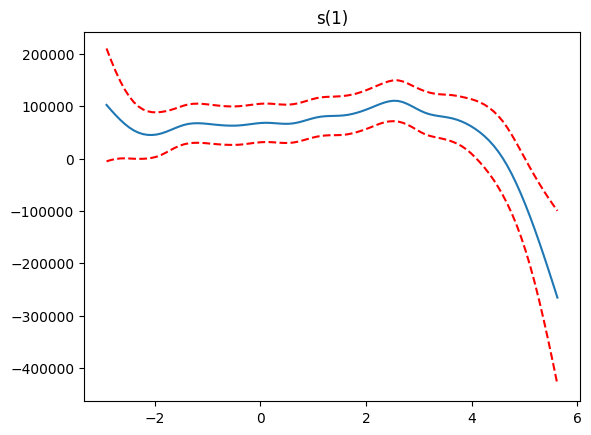

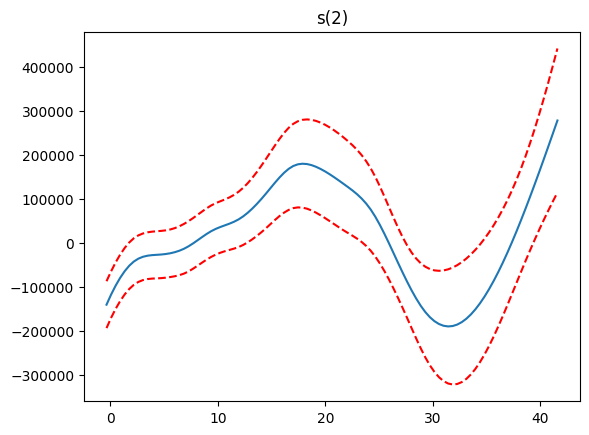

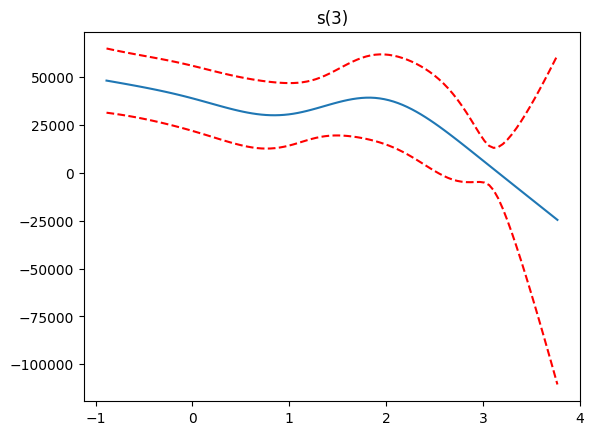

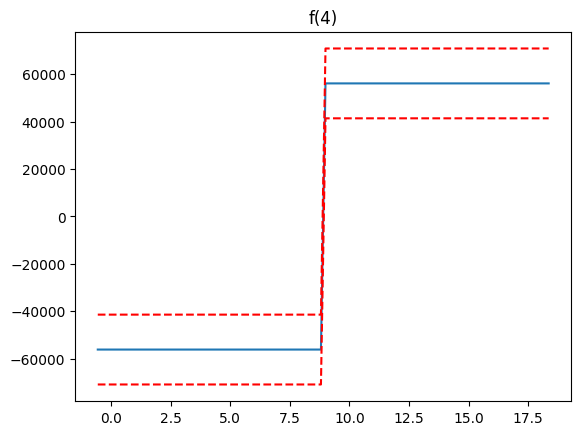

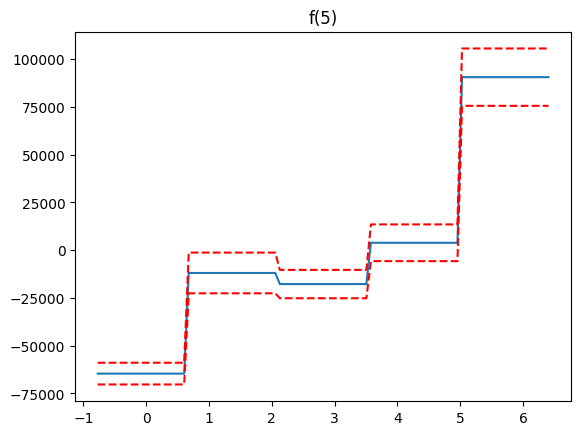

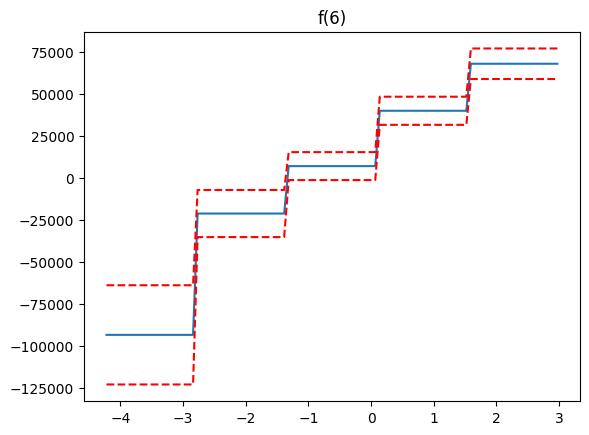

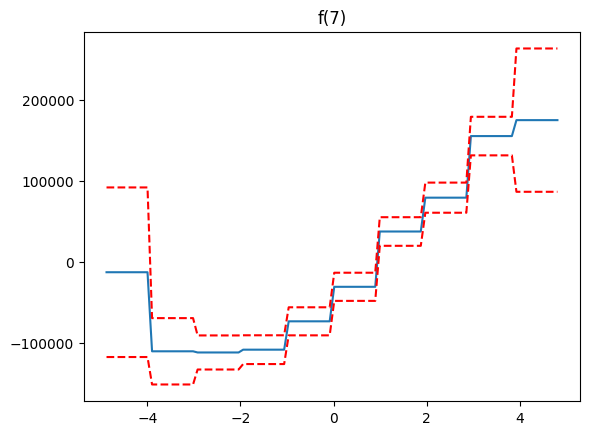

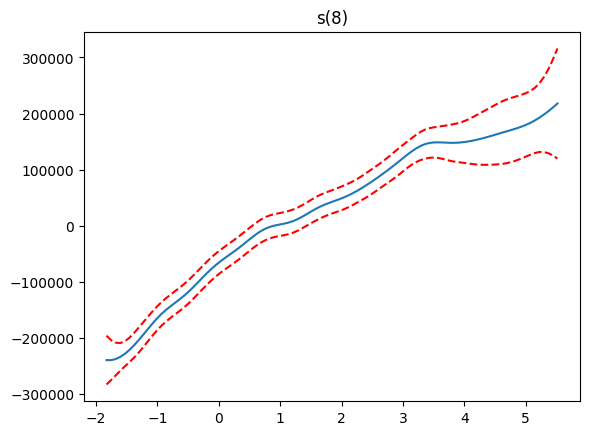

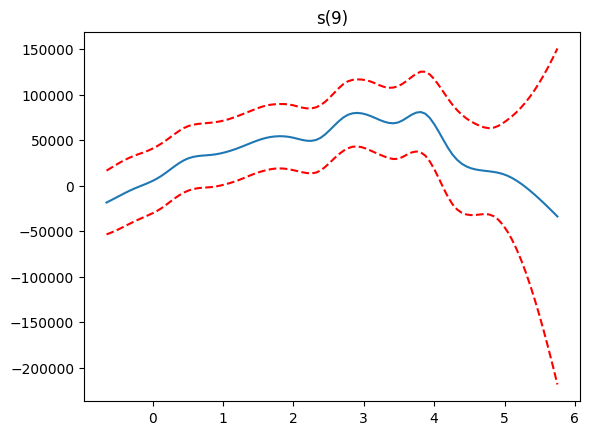

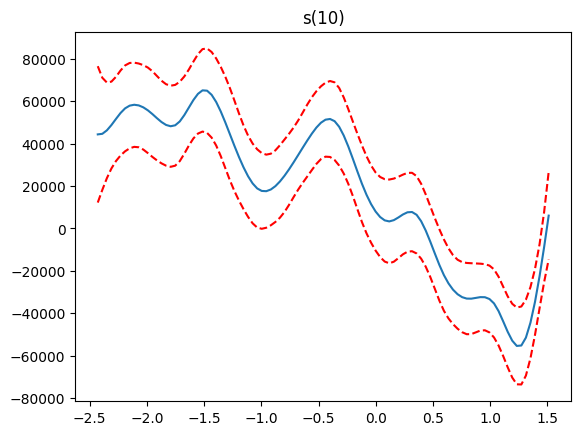

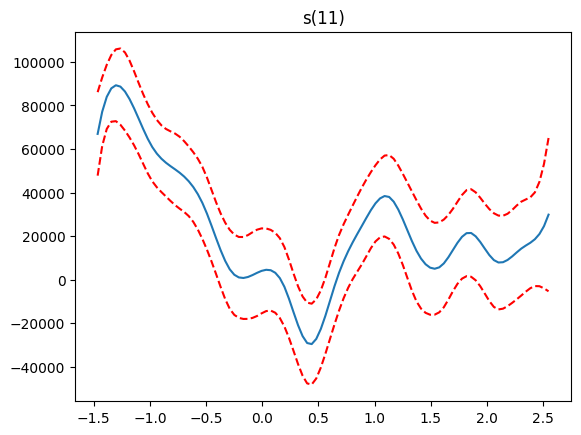

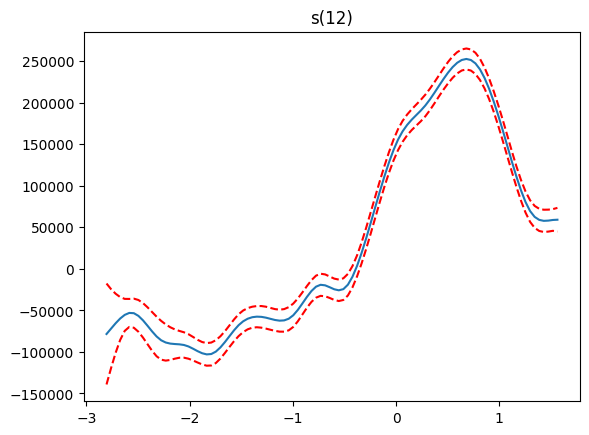

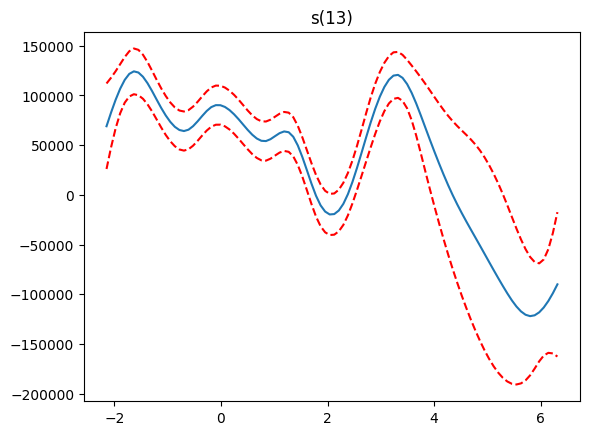

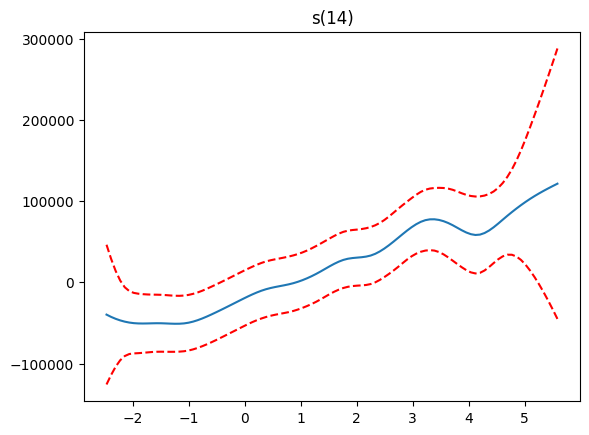

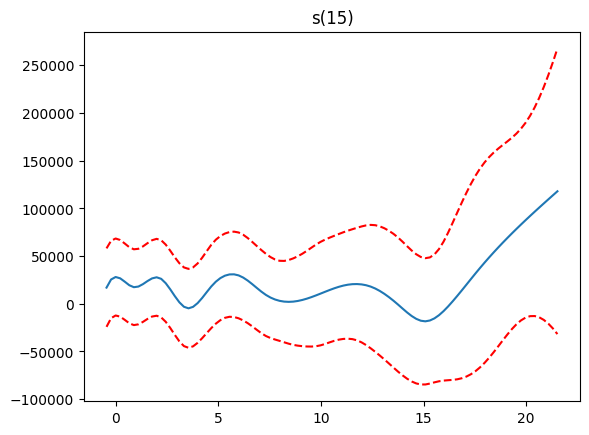

In [68]:
for i, term in enumerate(gam.terms):
    # Exlude interscept term
    if not term.isintercept:
        x_grid = gam.generate_X_grid(term=i)
        x, conf = gam.partial_dependence(term=i, X=x_grid, width=0.95)
    
        plt.figure()
        plt.plot(x_grid[:, term.feature], x)
        plt.plot(x_grid[:, term.feature], conf, c='r', ls='--')
        plt.title(repr(term))
        plt.show()

Based on EDFs and plots we decided to include terms 0, 3, 8, 14, and 15 as stright lines. 

In [69]:
gam = LinearGAM(l(0)+s(1)+s(2)+l(3)+f(4)+f(5)+f(6)+f(7)+l(8)+s(9)+s(10)+s(11)+s(12)+s(13)+l(14)+l(15)).fit(X_train_sc, y_train)
y_hat = gam.predict(X_test_sc)
mean_absolute_percentage_error(y_pred=y_hat, y_true=y_test)

np.float64(0.1539899753416038)

In the MLRM we found the the regressors with the maximal impact are grade and lat. Let's try a GAM with only grade and position regressors (lat and long):

In [31]:
# position, lat, long
gam = LinearGAM(f(7)+s(12)+s(13)).fit(X_train_sc, y_train)
y_hat = gam.predict(X_test_sc)
mean_absolute_percentage_error(y_pred=y_hat, y_true=y_test)

np.float64(0.20260075755952722)

Quite a decent result. The MAPE is 20.3%, similar to the best MLRM we've got. 

#### GAM: hyperparameter tuning
GAM has a hyperparameter $\lambda$ which controls the amount of smoothing. 

Because we have a lot of parameters, it would need to check a huge amount of permutations of $\lambda$. To speed it up we will use randomized grid search. We will generate 100 random sets of $\lambda$ and search for the best model hyperparameters among them.

In [32]:
# Generate 1000 random sets of 16 lambdas on a logarithmic scale from 10^-3 to 10^3
lams = np.random.rand(1000, 16) 
lams = lams * 6 - 3
lams = 10 ** lams
lams

array([[4.25493840e+02, 4.85086596e-01, 5.77146011e-03, ...,
        1.70247115e+00, 2.89063238e-01, 2.73948970e-01],
       [2.54953216e+01, 5.87690869e-01, 4.97235912e+01, ...,
        3.90667750e+01, 3.78085620e+00, 1.20372074e+01],
       [2.04910260e+01, 6.09082753e+00, 5.82582291e-03, ...,
        8.50040765e-01, 4.88311454e+00, 1.12166033e+00],
       ...,
       [4.44248250e-01, 3.09308681e-02, 6.29192088e-03, ...,
        7.43968280e-01, 2.84817247e-03, 4.99800274e+01],
       [2.02711097e+02, 7.44751623e+02, 1.55520166e+01, ...,
        1.70446967e+00, 3.58113398e+00, 1.04377362e+01],
       [3.41974356e-03, 1.93290981e+02, 2.88689587e+01, ...,
        1.13774334e-02, 2.74510163e-01, 1.55072380e-02]])

In [33]:
random_gam = LinearGAM(l(0)+s(1)+s(2)+l(3)+f(4)+f(5)+f(6)+f(7)+l(8)+s(9)+s(10)+s(11)+s(12)+s(13)+l(14)+l(15)
                      ).gridsearch(X_train_sc, y_train, lam=lams)
random_gam.summary()

100% (1000 of 1000) |####################| Elapsed Time: 0:06:20 Time:  0:06:200331


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     108.412
Link Function:                     IdentityLink Log Likelihood:                               -387837.7047
Number of Samples:                        16326 AIC:                                           775894.2334
                                                AICc:                                          775895.7233
                                                GCV:                                       8378297541.3695
                                                Scale:                                     8278212875.5088
                                                Pseudo R-Squared:                                   0.8095
Feature Function                  Lam

/var/folders/w0/s_wz2zzx3ls7nn9kbl_5n25r0000gp/T/ipykernel_85055/24814728.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  random_gam.summary()


In [34]:
y_hat = random_gam.predict(X_test_sc)
mean_absolute_percentage_error(y_pred=y_hat, y_true=y_test)

np.float64(0.15439197587935047)

GAM solves an issue with non-linear dependencies. Because of that, it performs better than MLRM. MAPE is 15.4% comparing to 20% for MLRM.

#### LightGBM
Let's give a chance to decision tree ansabmble. For this purpose, we've selected LightGBM. It is a gradient-boosting machine that uses a histogram-based algorithm to speed up training. It deals better than XGBoost with big datasets. 

Lets first fit the model with the default hyperparameters:

In [70]:
model = LGBMRegressor(verbose=-1)
model.fit(X_train_sc, y_train)

LGBMRegressor(verbose=-1)

In [71]:
y_hat = model.predict(X_test_sc)
mean_absolute_percentage_error(y_pred=y_hat, y_true=y_test)

np.float64(0.11868423729738001)

Even without hyperparameter optimization, it gives the best results among the models we tested. MAPE is 11.9% compared to 15.4 for the GAM model.

#### LightGBM: hyperparameter tuning
Let's try to do hyperparameter optimization to choose a better-performing model.

This time we will use grid search with cross-validation and k-fold with several folds equal to 5

In [37]:
params = {
    'learning_rate': [0.03, 0.003],
    'n_estimators': [100, 500],
    'bagging_fraction': [0.6, 0.8],
    'bagging_freq': [5, 10],
}

grid = GridSearchCV(lgb.LGBMRegressor(random_state=0, verbose=-1), params, cv=5)
grid.fit(X_train_sc, y_train)

reg = lgb.LGBMRegressor(random_state=0)
reg.fit(X_train_sc, y_train)

lgbm_tuned = grid.best_estimator_

In [38]:
y_hat = lgbm_tuned.predict(X_test_sc)
mean_absolute_percentage_error(y_pred=y_hat, y_true=y_test)

np.float64(0.11573538739140454)

In [39]:
lgbm_tuned

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, learning_rate=0.03,
              n_estimators=500, random_state=0, verbose=-1)

#### Models Performance

We tried three different models: multiple Linear Regression Model, Generalized Additive Model, and Gradient Boosting Machine (LightGBM).

The results are the next:
| Model | MAPE |
| --- | --- |
| MLRM | 20.2% |
| GAM | 15.4% |
| LightGBM | 11.6% |

Based on the Mean Absolute Percentage Error we selected LoghtGBM model with the next parameters:
* bagging_fraction=0.8
* bagging_freq=5 
* learning_rate=0.03
* n_estimators=500

## Conclusion
In conclusion, our project aimed to evaluate and compare the effectiveness of the Multiple Linear Regression Model (MLRM), Generalized Additive Models (GAM), and LightGBM in predicting house prices. After extensive analysis and experimentation, it became evident that LightGBM outperformed both MLR and GAM in terms of predictive accuracy. The reason for this is the ability of gradient-boosted decision trees to handle complex relationships within the dataset. Although we didn't explicitly test the computational efficiency, LightGBM is known to be one of the best in this area.

While MLRM and GAM provided valuable insights and were easier to interpret, they fell short of delivering the same level of precision as LightGBM.

Ultimately, the results of this project highlight the importance of model selection in predictive analytics. Given the complexity and variability inherent in housing market data, LightGBM stands out as the most robust choice for house price prediction, offering not only superior performance but also the flexibility needed to adapt to evolving market trends. This finding can guide real estate stakeholders in making more informed decisions based on accurate price predictions, enhancing investment strategies and market analysis.

## Citations
1. [House Sales in King County, USA](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction?resource=download)
2. [pyGAM](https://pygam.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)
4. [Grade and Quality values](https://storage.googleapis.com/kaggle-forum-message-attachments/2223974/18989/Grade%20and%20condition%20from%20king%20county%20system.jpg)